<a href="https://colab.research.google.com/github/pedromasb/tutorials/blob/main/notebooks/gridsearch_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Using Grid Search For Autoencoder Hyperparameter Tuning </center></h1>

Created by

**[Pedro Mas Buitrago](https://pedromasb.github.io/)**

**Last updated** by the author in May 2023

For a smoother development of the tutorial, the user can turn on one of the hardware accelerators provided by Colab. For this, go to "Edit" in the top menu, select "Notebook settings" and choose one of the available GPU options.

---

In this brief tutorial, we will see how we can use the grid search tuning technique for the hyperparameter optimization of a deep sparse autoencoder. You can learn about how autoencoders work [here](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798). We will use the well known [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits, which is available through the ``tensorflow.keras.datasets`` module.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from joblib import dump, load

from tensorflow.keras.datasets import mnist

## Data load and exploration

We load the data and normalize all values between 0 and 1. Let´s visualize the first 10 28x28 images of the training set.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

print(f' Train set: {x_train.shape} \n Test set: {x_test.shape}')

11490434/11490434 [==============================] - 1s 0us/step
 Train set: (60000, 28, 28) 
 Test set: (10000, 28, 28)


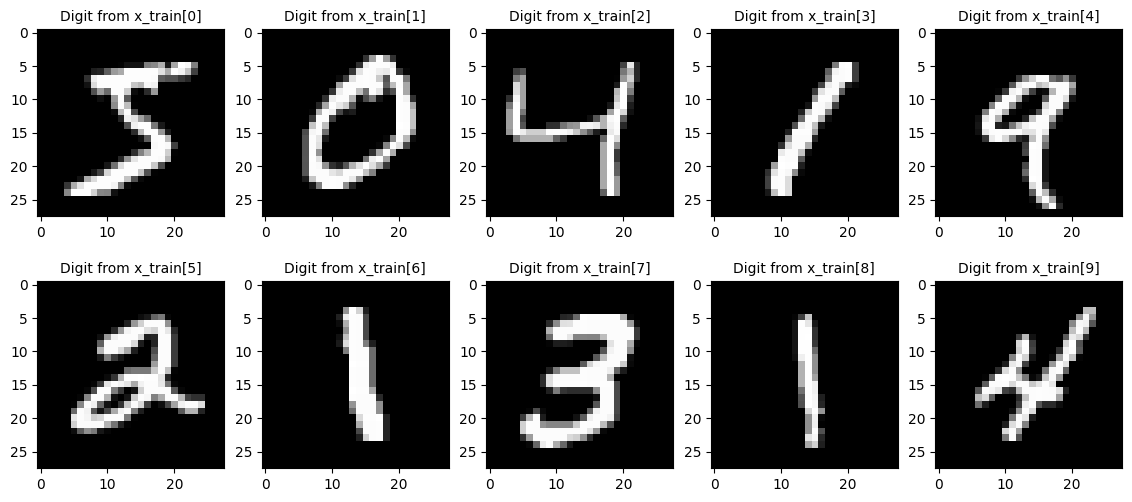

In [3]:
n = 10

fig = plt.figure(figsize=(14,6))

for i in range(n):
    ax = plt.subplot(math.ceil(n/5),5, i+1)
    ax.imshow(x_train[i],cmap='gray')
    ax.set_title(f'Digit from x_train[{i}]',fontsize=10)
    
plt.show()

To prepare the data for our model, we flatten each 28x28 image into a vector of size 784.

In [4]:
x_train = x_train.reshape(len(x_train),np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test),np.prod(x_test.shape[1:]))

print(f' Train set: {x_train.shape} \n Test set: {x_test.shape}')

 Train set: (60000, 784) 
 Test set: (10000, 784)


## Grid search for hyperparameter optimization

First, we define a function to build the autoencoder including the parameters we want to iterate in the grid search, which will be ``neurons_in`` (number of neurons in the first and last dense layers) and ``reg_par`` (regularization factor). In our case, we build an autoencoder with 3 dense layers, both in the encoder and decoder, and with a 32-dimensional latent space.

Then, we define the parameter space that we want to explore in the grid search and wrap the Keras model using the ``KerasRegressor`` class, so we can use the ``GridSearchCV`` class form the sklearn package.

In [5]:
def build_autoencoder(neurons_in=None,reg_par=None):
    
    input_l = Input(shape=(784,),name='input_l')

    encoded_l1 = Dense(int(neurons_in), activation='relu', name='encoded_1', activity_regularizer=regularizers.l1(reg_par))(input_l) 
    encoded_l2 = Dense(int(neurons_in*1/2), activation='relu', name='encoded_2', activity_regularizer=regularizers.l1(reg_par))(encoded_l1)
    encoded_l3 = Dense(int(neurons_in*1/4), activation='relu', name='encoded_3', activity_regularizer=regularizers.l1(reg_par))(encoded_l2)

    bottleneck = Dense(32, activation='relu', name='bottleneck')(encoded_l3)

    decoded_l1 = Dense(int(neurons_in*1/4), activation='relu', name='decoded_3', activity_regularizer=regularizers.l1(reg_par))(bottleneck)
    decoded_l2 = Dense(int(neurons_in*1/2), activation='relu', name='decoded_4', activity_regularizer=regularizers.l1(reg_par))(decoded_l1)
    decoded_l3 = Dense(int(neurons_in), activation='relu', name='decoded_5', activity_regularizer=regularizers.l1(reg_par))(decoded_l2)

    output_l = Dense(784, activation='sigmoid', name='output_l')(decoded_l3)

    ac = Model(input_l,output_l)
    
    ac.compile(loss='mse', optimizer='adam')
    
    return ac

As our purpose is only to illustrate the process, we use a very small parameter space so that the grid search does not take too long.

In [6]:
param_grid = [{'neurons_in':[2**8,2**9],'reg_par':[1e-8,1e-7]}]

In [7]:
autoencoder_base = KerasRegressor(build_autoencoder,verbose=0,neurons_in=[2**8,2**9],reg_par=[1e-8,1e-7])
autoencoder_base.get_params().keys()

<ipython-input-7-0194b47abef2>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  autoencoder_base = KerasRegressor(build_autoencoder,verbose=0,neurons_in=[2**8,2**9],reg_par=[1e-8,1e-7])


dict_keys(['verbose', 'neurons_in', 'reg_par', 'build_fn'])

We perform the grid search and check the mean CV test score for each combination of hyperparameters.

Note that the score metric used is the negative MSE. This is because the scoring API of ``GridSearchCV`` always tries to maximise its score, so loss functions like MSE are negated.

In [ ]:
grid = GridSearchCV(estimator=autoencoder_base, param_grid=param_grid, verbose=1, cv=3,scoring='neg_mean_squared_error')

history = grid.fit(x_train,x_train,
                   epochs=15,
                   batch_size=128, 
                   shuffle=True,
                   validation_data=(x_test, x_test))

gs_results = history.cv_results_

print('\n\n CV results:')

for mean_score, params in zip(gs_results['mean_test_score'],gs_results['params']):
    print(mean_score,params)

best_params = history.best_params_
best_score = history.best_score_

print(f"\n\n The best Hyperparameter combination is:\n {best_params} \n with a mean test score of: {best_score}")    

Fitting 3 folds for each of 4 candidates, totalling 12 fits


 CV results:
-0.010627052168870693 {'neurons_in': 256, 'reg_par': 1e-08}
-0.01037600100720361 {'neurons_in': 256, 'reg_par': 1e-07}
-0.007897123366696786 {'neurons_in': 512, 'reg_par': 1e-08}
-0.008170491665180383 {'neurons_in': 512, 'reg_par': 1e-07}


 The best Hyperparameter combination is:
 {'neurons_in': 512, 'reg_par': 1e-08} 
 with a mean test score of: -0.007897123366696786


We can save the ``GridSearchCV`` object as a Pickle (.pkl) file, using the ``joblib`` package, so we don´t have to perform it again. 

In [ ]:
dump(grid,'grid_search_ac.pkl')

['grid_search_ac.pkl']

## Training of the best autoencoder

Once we know the optimal combination of hyperparameters, we can properly train our final autoencoder. Here, we also define the encoder sub-model, as our final objective is to find a good compressed representation of the input data.

In [8]:
neurons_in = best_params['neurons_in']
reg_par = best_params['reg_par']

input_l = Input(shape=(784,),name='input_l')

encoded_l1 = Dense(int(neurons_in), activation='relu', name='encoded_1')(input_l) 
encoded_l2 = Dense(int(neurons_in*1/2), activation='relu', name='encoded_2', activity_regularizer=regularizers.l1(reg_par))(encoded_l1)
encoded_l3 = Dense(int(neurons_in*1/4), activation='relu', name='encoded_3', activity_regularizer=regularizers.l1(reg_par))(encoded_l2)

bottleneck = Dense(32, activation='relu', name='bottleneck')(encoded_l3)

decoded_l1 = Dense(int(neurons_in*1/4), activation='relu', name='decoded_3', activity_regularizer=regularizers.l1(reg_par))(bottleneck)
decoded_l2 = Dense(int(neurons_in*1/2), activation='relu', name='decoded_4', activity_regularizer=regularizers.l1(reg_par))(decoded_l1)
decoded_l3 = Dense(int(neurons_in), activation='relu', name='decoded_5', activity_regularizer=regularizers.l1(reg_par))(decoded_l2)

output_l = Dense(784, activation='sigmoid', name='output_l')(decoded_l3)

ac = Model(input_l,output_l)
ec = Model(input_l,bottleneck)

ac.compile(loss='mse',optimizer='adam')

In [9]:
ac.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_l (InputLayer)        [(None, 784)]             0         
                                                                 
 encoded_1 (Dense)           (None, 512)               401920    
                                                                 
 encoded_2 (Dense)           (None, 256)               131328    
                                                                 
 encoded_3 (Dense)           (None, 128)               32896     
                                                                 
 bottleneck (Dense)          (None, 32)                4128      
                                                                 
 decoded_3 (Dense)           (None, 128)               4224      
                                                                 
 decoded_4 (Dense)           (None, 256)               33024 

In [10]:
ec.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_l (InputLayer)        [(None, 784)]             0         
                                                                 
 encoded_1 (Dense)           (None, 512)               401920    
                                                                 
 encoded_2 (Dense)           (None, 256)               131328    
                                                                 
 encoded_3 (Dense)           (None, 128)               32896     
                                                                 
 bottleneck (Dense)          (None, 32)                4128      
                                                                 
Total params: 570,272
Trainable params: 570,272
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = ac.fit(x_train,x_train,
                epochs=50,
                batch_size=128,
                verbose=1,
                shuffle=True,validation_split=0.2) 

Epoch 1/50
375/375 [==============================] - 9s 6ms/step - loss: 0.0451 - val_loss: 0.0247
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0207 - val_loss: 0.0181
Epoch 3/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 5/50
375/375 [==============================] - 3s 7ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 8/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 9/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 10/50
375/375 [==============================] - 2s 5ms/step - loss: 0.0088 - val_loss: 0.0093

We can plot the loss and validation loss to see their evolution during the training process and confirm that they properly converge.

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

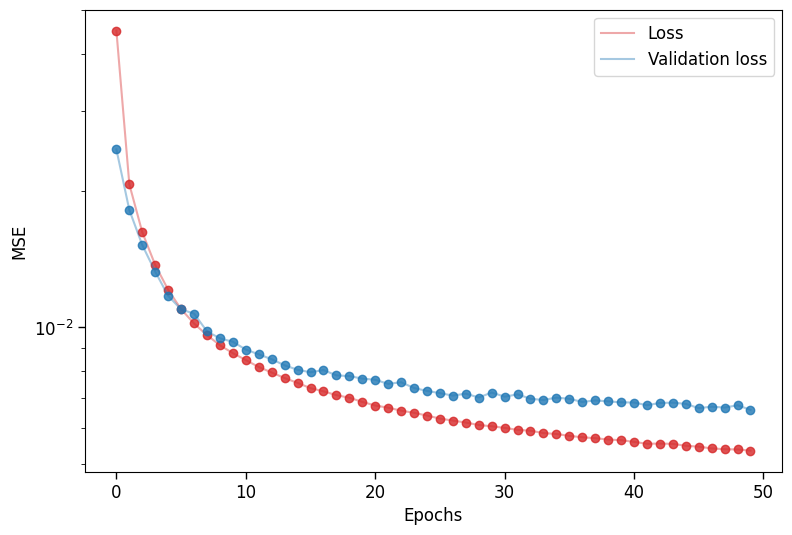

In [13]:
fig, ax = plt.subplots(figsize=(9,6))

ax.set_ylabel('MSE',fontsize=12)
ax.set_xlabel('Epochs',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12,width=1,length=5)
ax.tick_params(axis='both', which='minor', labelsize=8, length=3)
ax.set_yscale('log')

ax.plot(loss,color='tab:red',alpha=0.4,label='Loss')
ax.plot(loss,'.',color='tab:red',alpha=0.8,markersize=12)

ax.plot(val_loss,color='tab:blue',alpha=0.4,label='Validation loss')
ax.plot(val_loss,'.',color='tab:blue',alpha=0.8,markersize=12)

plt.legend(fontsize=12)
plt.show()

## Visualization of the reconstructed digits

Now that we have trained the optimal autoencoder, it is time to check the reconstructed images. We can also have a look at the compressed representations provided by the encoder (we reshape them to 4x8 for visualization purposes).

In [14]:
encoded_imgs = ec.predict(x_test)
predicted_imgs = ac.predict(x_test)

313/313 [==============================] - 1s 2ms/step


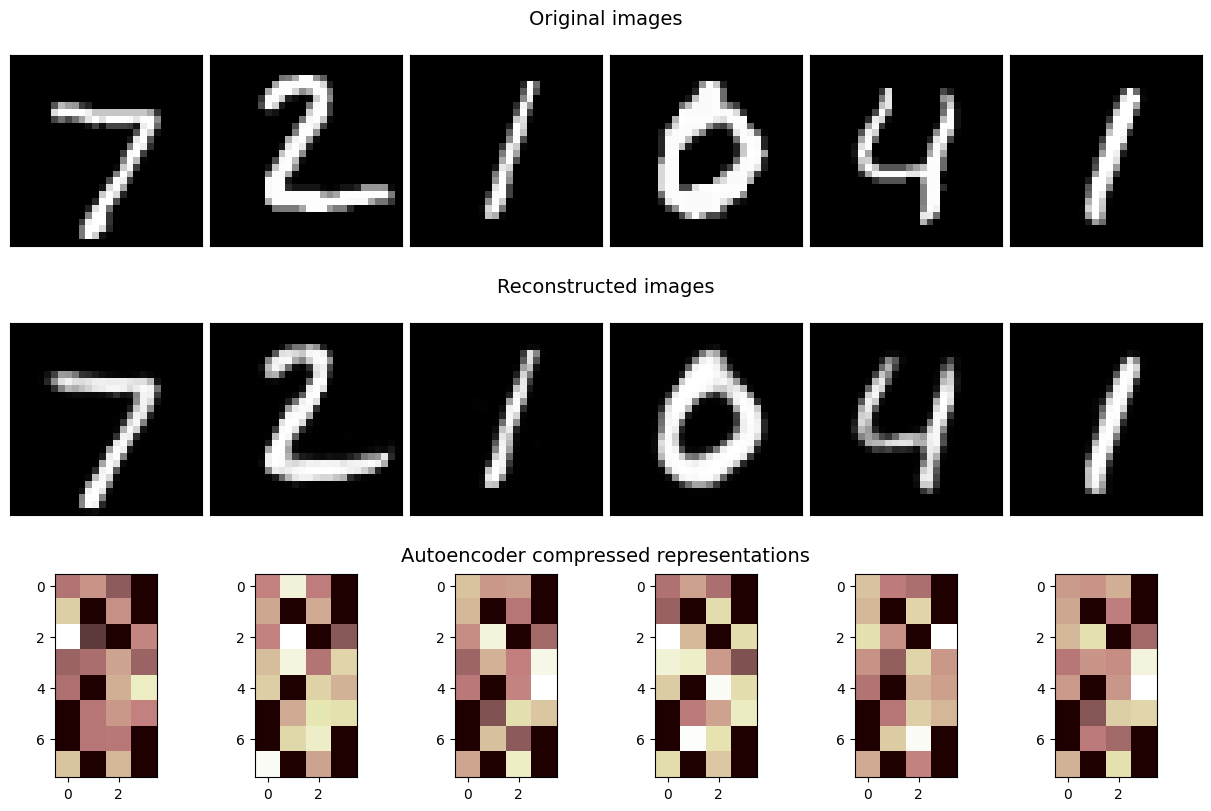

In [15]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)

subfigs[0].suptitle('Original images',fontsize=14)

axs1 = subfigs[0].subplots(nrows=1, ncols=6)

for i in range(6):
  axs1[i].imshow(x_test[i].reshape(28,28),cmap='gray')
  axs1[i].get_xaxis().set_visible(False)
  axs1[i].get_yaxis().set_visible(False)

subfigs[1].suptitle('Reconstructed images',fontsize=14)

axs2 = subfigs[1].subplots(nrows=1, ncols=6)

for i in range(6):
  axs2[i].imshow(predicted_imgs[i].reshape(28,28),cmap='gray')
  axs2[i].get_xaxis().set_visible(False)
  axs2[i].get_yaxis().set_visible(False)

subfigs[2].suptitle('Autoencoder compressed representations',fontsize=14)

axs3 = subfigs[2].subplots(nrows=1, ncols=6)

for i in range(6):
  axs3[i].imshow(encoded_imgs[i].reshape(8,4),cmap='pink')
